# Homework 1 - Score index
BEN BELHASSEN Mohamed Ali, CIAMPANA Lorenzo, FILESI Gianluca, NUBE Giacomo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os # Asked to ChatGPT how to go through the files
import sys
import kneed
import scipy.spatial.distance as sc_dist
import scipy.cluster.hierarchy as sc
from scipy.spatial import distance_matrix

### Path and data

In [2]:
User = 'G' # G or L

if User == 'G':
    path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/01 DATA MINING/Data Mining/HW1/Sleeping_record_all_zip/'
else:
    path = '/Users/lorenzociampana/Desktop/EDHEC/Data Mining/Sleeping_record_all_zip/'

data_0 = pd.read_excel(path+'Sleeping_record_0.xlsx')

### Functions

In [3]:
def Euclidean_dist(x1,x2):
    if(hasattr(x1, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        x1 = x1.to_numpy() ## If not Numpy type: we assume this is a dataframe.
        x2 = x2.to_numpy() ## If not Numpy type: we assume this is a dataframe.
    
        
    if(np.size(x1)!=np.size(x2)): ## Checking dimension 
        sys.exit("Dimension issue")
    if(np.ndim(x1)<=1): ## If one dimensional array: Euclidean over the rows --> scalar
        euc_dist = np.sqrt(np.sum((x1-x2)**2))
    else: ## Nxd array --> Euclidean distance for each row (sum over the columns)
        euc_dist= np.sqrt(np.sum((x1-x2)**2,axis=1))
        
    return euc_dist

In [4]:
def Kmeans_algo(y,nb_K=3,replic=5):
    if(hasattr(y, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        y = y.to_numpy()
     
    N = len(y) ## Number of observations
    if(len(np.shape(y))==1): ## If dimension=1: need to compute Euclidean distance for each observation (trick to set the vector into a matrix Nx1)
        y = np.array(y,ndmin=2).transpose()
    
    dimension = np.shape(y)[1]
    ### Initialisation of the K-means algorithm
    mu = np.zeros([nb_K,dimension])
    dist = np.zeros([N,nb_K])
    idx_save = np.zeros([N,500]) ## idx_save will save all the partitions found by the K-means algorithm
    if(nb_K>1): ## To initialize the algorithm, it requires a partition. 
        nb_init = 20
        dist_start = np.zeros(nb_init)
        idx_start = np.zeros([N,replic])
        for i in range(replic):
            prob = ((i+1))/(2*replic)
            idx_prop = np.zeros([N,nb_init],dtype=int)
            for j in range(nb_init):
                idx_prop[:,j] = np.sum(np.random.rand(N,nb_K)>prob,axis=1).astype(int)  ## Simulation
                for k in range(nb_K): ### Computation of the mean of each cluster
                    if(np.sum(idx_prop[:,j]==k)>0):
                        mu[k,:] = np.mean(y[idx_prop[:,j]==k,:],axis=0)
                for k in range(nb_K):
                    dist[:,k] = Euclidean_dist(y,np.tile(mu[k,:],[N,1]))
                dist_start[j] = np.sum(np.min(dist,axis=1)**2)
            
            idx_start[:,i] = idx_prop[:,np.argmin(dist_start)]        
    
        
    for i in range(replic): ## Number of times that the K-means is run (to avoid to find a sub-optimal solution)
        ### Initialisation of the K-means algorithm
        mu = np.zeros([nb_K,dimension])
        
        if(nb_K>1):
            idx = idx_start[:,i] ## Take at each replication, a partition with a different standard deviation
            # idx = idx_start[:,idx_to_select[int(np.floor(i*nb_init/replic) + 1)]] ## Take at each replication, a partition with a different standard deviation
        else: idx = np.zeros(N)
        
        
        ######################
        ### K-means algorithm
        convergence = 0
        idx_save[:,0] = idx
        count = 0
        while(convergence==0): ### While the partition is changing from one iteration to the other
            for k in range(nb_K): ### Computation of the mean of each cluster
                if(np.sum(idx==k)>0):
                    mu[k,:] = np.mean(y[idx==k,:],axis=0)
            
            ## Computation of the distance of each observation to each cluster mean
            idx_prev = idx.copy()
            for k in range(nb_K):
                dist[:,k] = Euclidean_dist(y,np.tile(mu[k,:],[N,1]))
            ## Find the partition such that all the observations are to the closest distance with respect to the cluster mean    
            idx = np.argmin(dist,axis=1)
            if(np.sum(idx==idx_prev)==N): ## If the current partition is the same as the previous one: end of the K-mean algorithm
                convergence = 1
            
            count = count +1
            idx_save[:,count] = idx ## Saving the current partition
            
        ### Once the K-means has converged, we save the optimal partition and compute the distance, inertia
        sq_dist = 0
        for k in range(nb_K):
            sq_dist = sq_dist + np.sum(dist[idx==k,k]**2)
            
        if(i==0):
            idx_all = idx_save[:,0:(count+1)]
            idx_best = idx
            sq_dist_best = sq_dist
        elif(sq_dist<sq_dist_best):
            idx_all = idx_save[:,0:(count+1)]
            idx_best = idx
            sq_dist_best = sq_dist
    
    
    return  idx_best,idx_all,sq_dist_best


In [5]:
def Mahanalobis_dist(data,mu=None,cov=None):
## Inputs: 
    ## data: Two possibilities: 
        ## np array (NxK) or NxK dataframe
        ## One dimensional array or a one dimensional dataframe if so Need to provide the covariance and the mean. 
    ## (Optional) mu: Only useful if the provided data is one dimensional
        # Kx1 vector (array)
    ## (Optional) cov: Only useful if the provided data is one dimensional
        # KxK positive definite covariance matrix
## Output:
    ## Manahalobis distance of the datapoints (Array Nx1)
    if(hasattr(data, 'to_numpy')): ## Checking if the input is Numpy type or DataFrame type 
        y = np.array(data.to_numpy(),ndmin=2) ## If not Numpy type: we assume this is a dataframe.
    else:
        y = data
        
    if(np.ndim(y)==1):
        if cov is None:sys.exit('Covariance should be provided')
        
        if mu is None:sys.exit('mu should be provided')
        
        if(np.size(y)==1):
            mana = (y-mu)**2/cov ## Univariate
        else:
            inv_covmat = np.linalg.inv(cov)
            y_mu = np.array(y - mu,ndmin=2) ## array 1xK
            mana = np.matmul(y_mu,np.matmul(inv_covmat,y_mu.transpose()))
    else:
        if(np.size(y,0)<np.size(y,1)):## Ensure that the array is of size NxK
            y = y.transpose()
        
        if cov is None:
            cov = np.cov(y.transpose())
        
        if mu is None:
            mu = np.mean(y,axis=0)
        
        N = np.size(y,0)
        y_mu = y - np.tile(mu,[N,1]) ## to perform matrix multiplication
        inv_covmat = np.linalg.inv(cov)
        
        mana = np.zeros([N])
        for i in range(N):
            mana[i] = np.sqrt(np.matmul(y_mu[i,:],np.matmul(inv_covmat,y_mu[i,:]))) 
    return mana

In [6]:
def compute_inertia(Prox_mat,method_name=None,nb_cluster_max=10):
    if(method_name is None):method_name='single'
    
    N = np.size(Prox_mat,0)
    if(nb_cluster_max>N):nb_cluster_max = N
    
    output_pdist = sc_dist.squareform(Prox_mat)
    output_linkage = sc.linkage(output_pdist, method=method_name)
    
    inertia = np.zeros([nb_cluster_max])
    for i in range(nb_cluster_max):
        clust = sc.cut_tree(output_linkage,n_clusters=(i+1))
        count_clust = np.zeros(i+1)
        for j in range((i+1)):
            count_clust[j] = np.sum(clust==j)
            
        inertia[i] = np.max(count_clust)
    
    return inertia

In [7]:
### Function to find the optimal number of clusters
### It computes the minimum distance for a range of number of clusters
### For each number of clusters, the function runs a K-means algorithm
  ## Inputs: 
      ## y: Two possibilities: 
          ## np array (Nxd) or Nxd dataframe
          ## One dimensional array or a one dimensional dataframe
      ## max_k: Maximum number of clusters (default=5)    
      ## replic: Number of replication of the algorithm to find the best partition (default=5)
  ## Output is a list of one element:
      ## dist: vector containing the squared distance for a range of number of clusters
def dist_per_cluster(y,max_k,replic=5):
    dist = np.zeros([max_k])
    for k in range(max_k):## For each number of cluster: run a K-means algorithm and store the distance
        output = Kmeans_algo(y,k+1,replic)
        dist[k] = output[2]
    
    return dist

# 1. Data Exploration

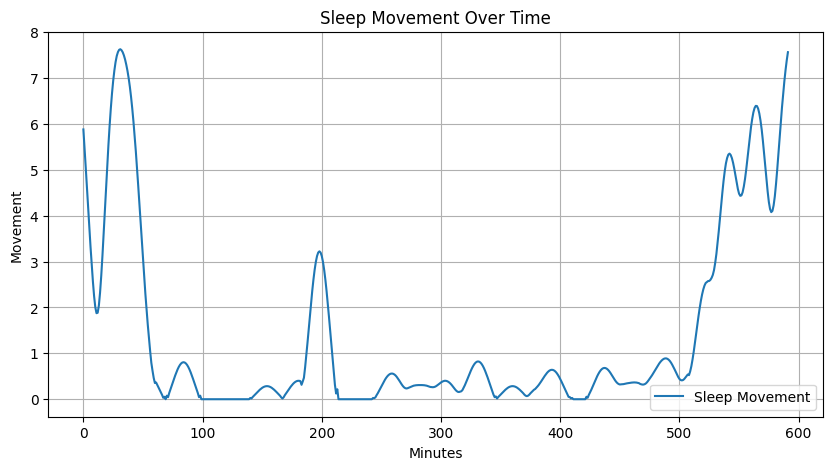

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(data_0['activityLevel'], label='Sleep Movement')
plt.xlabel('Minutes')
plt.ylabel('Movement')
plt.title('Sleep Movement Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
mean = data_0['activityLevel'].mean()
var = data_0['activityLevel'].var()
std = np.sqrt(var)
median = data_0['activityLevel'].median()

print(pd.DataFrame([mean, std, median], columns=['Summary Statistics'], index=['Mean', 'Variance', 'Standard Deviation']))

                    Summary Statistics
Mean                          1.380745
Variance                      2.034380
Standard Deviation            0.386957


# 2. Deep Sleep Duration

In [10]:
deep_sleep_periods = data_0[data_0['activityLevel'] == 0]  
total_deep_sleep_minutes = deep_sleep_periods.shape[0]

print(f"Total deep sleep time: {total_deep_sleep_minutes} minutes")

Total deep sleep time: 82 minutes


# 3. Sleep State Classification with K-means

In [11]:
non_deep_sleep = data_0[data_0['activityLevel'] > 0].copy()
non_deep_sleep2 = data_0[data_0['activityLevel'] > 0].copy().reset_index(drop=True)
output_Kmean = Kmeans_algo(non_deep_sleep,nb_K=3,replic=5)
idx_best,idx_all,sq_dist_best = output_Kmean
non_deep_sleep['State'] = 'unknown'
states = {0: 'light', 1: 'paradoxical (REM) sleep', 2: 'awake'}

mean_activity = np.zeros([3])
for i in range(3):
    mean_activity[i] = non_deep_sleep.loc[non_deep_sleep.index[idx_best == i]]['activityLevel'].mean()

ordering_states = np.argsort(mean_activity)
for cluster_id, state in states.items():
    non_deep_sleep.loc[non_deep_sleep.index[idx_best == ordering_states[cluster_id]], 'State'] = state
non_deep_sleep

,activityLevel,State
0,5.881820,awake
1,5.471038,awake
2,5.042299,awake
3,4.603892,awake
4,4.164630,paradoxical (REM) sleep
...,...,...
587,6.657375,awake
588,6.930700,awake
589,7.174108,awake
590,7.385978,awake


In [12]:
total_non_deep_sleep_minutes = []
for cluster_id, state in states.items():
    total_non_deep_sleep_minutes.append(non_deep_sleep[non_deep_sleep['State'] == state].shape[0])

print(f"Total light sleep time: {total_non_deep_sleep_minutes[0]} minutes")
print(f"Total REM time: {total_non_deep_sleep_minutes[1]} minutes")
print(f"Total awake time: {total_non_deep_sleep_minutes[2]} minutes")

Total light sleep time: 363 minutes
Total REM time: 64 minutes
Total awake time: 83 minutes


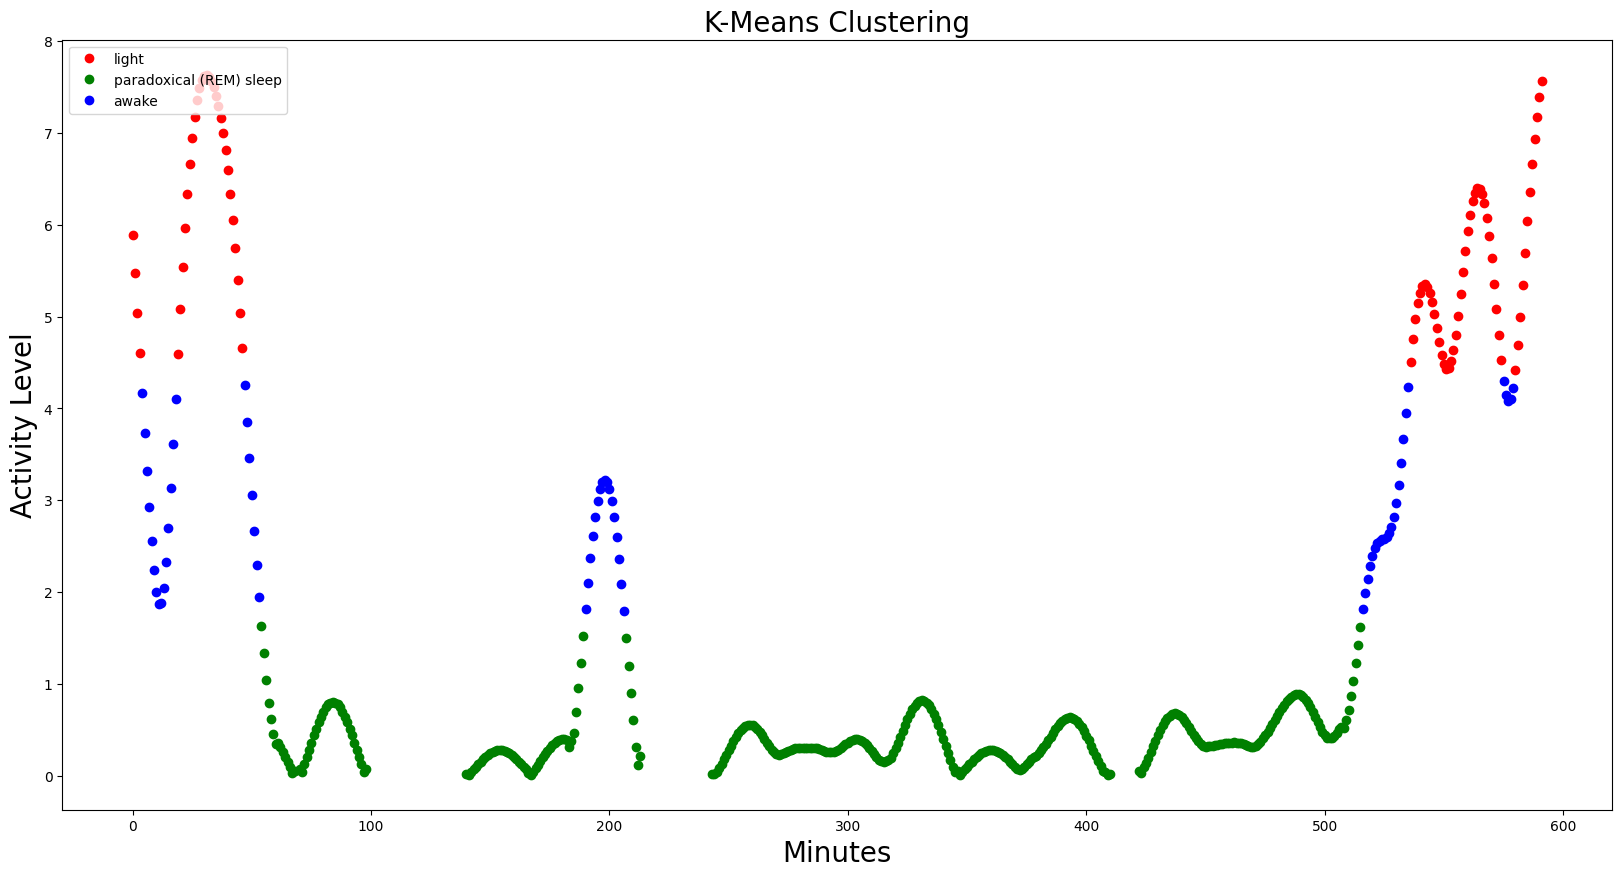

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(non_deep_sleep.index[idx_best == 0], non_deep_sleep['activityLevel'][idx_best == 0], 'or', label=states[0])
plt.plot(non_deep_sleep.index[idx_best == 1], non_deep_sleep['activityLevel'][idx_best == 1], 'og', label=states[1])
plt.plot(non_deep_sleep.index[idx_best == 2], non_deep_sleep['activityLevel'][idx_best == 2], 'ob', label=states[2])
plt.xlabel("Minutes", fontsize=20)
plt.ylabel("Activity Level", fontsize=20)
plt.title("K-Means Clustering", fontsize=20)
plt.legend(loc='upper left', fontsize=10)
plt.show()

# 4. Daily Sleep Analysis

In [14]:
sleeping_stats = []

# Loop through all Excel files in the folder using 'os' library
mean_activity = np.zeros([3])
for file_name in os.listdir(path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(path, file_name) 
        data = pd.read_excel(file_path)

        deep_sleep_periods = data[data['activityLevel'] == 0]  
        total_deep_sleep_minutes = deep_sleep_periods.shape[0]

        non_deep_sleep = data[data['activityLevel'] > 0].copy()
        output_Kmean = Kmeans_algo(non_deep_sleep,nb_K=3,replic=5)
        idx_best,idx_all,sq_dist_best = output_Kmean
        non_deep_sleep['State'] = 'unknown'

        for i in range(3):
            mean_activity[i] = non_deep_sleep.loc[non_deep_sleep.index[idx_best == i]]['activityLevel'].mean()

        ordering_states = np.argsort(mean_activity)
        states = {0: 'light', 1: 'paradoxical (REM) sleep', 2: 'awake'}
        for cluster_id, state in states.items():
            non_deep_sleep.loc[non_deep_sleep.index[idx_best ==  ordering_states[cluster_id]], 'State'] = state

        total_non_deep_sleep_minutes = []
        for cluster_id, state in states.items():
            total_non_deep_sleep_minutes.append(non_deep_sleep[non_deep_sleep['State'] == state].shape[0])

        daily_stats = {
            'Deep Sleep': total_deep_sleep_minutes,
            'Light Sleep': total_non_deep_sleep_minutes[0],
            'Paradoxical (REM) Sleep': total_non_deep_sleep_minutes[1],
            'Awake time': total_non_deep_sleep_minutes[2]
        }
        sleeping_stats.append(daily_stats)

sleeping_stats_df = pd.DataFrame(sleeping_stats)
sleeping_stats_df

,Deep Sleep,Light Sleep,Paradoxical (REM) Sleep,Awake time
0,66,390,19,97
1,56,413,52,54
2,108,306,66,58
3,132,338,68,68
4,67,486,69,67
...,...,...,...,...
133,80,416,137,59
134,66,548,121,62
135,58,342,79,48
136,100,394,53,73


To save time, the following subplots has been written by ChatGPT.

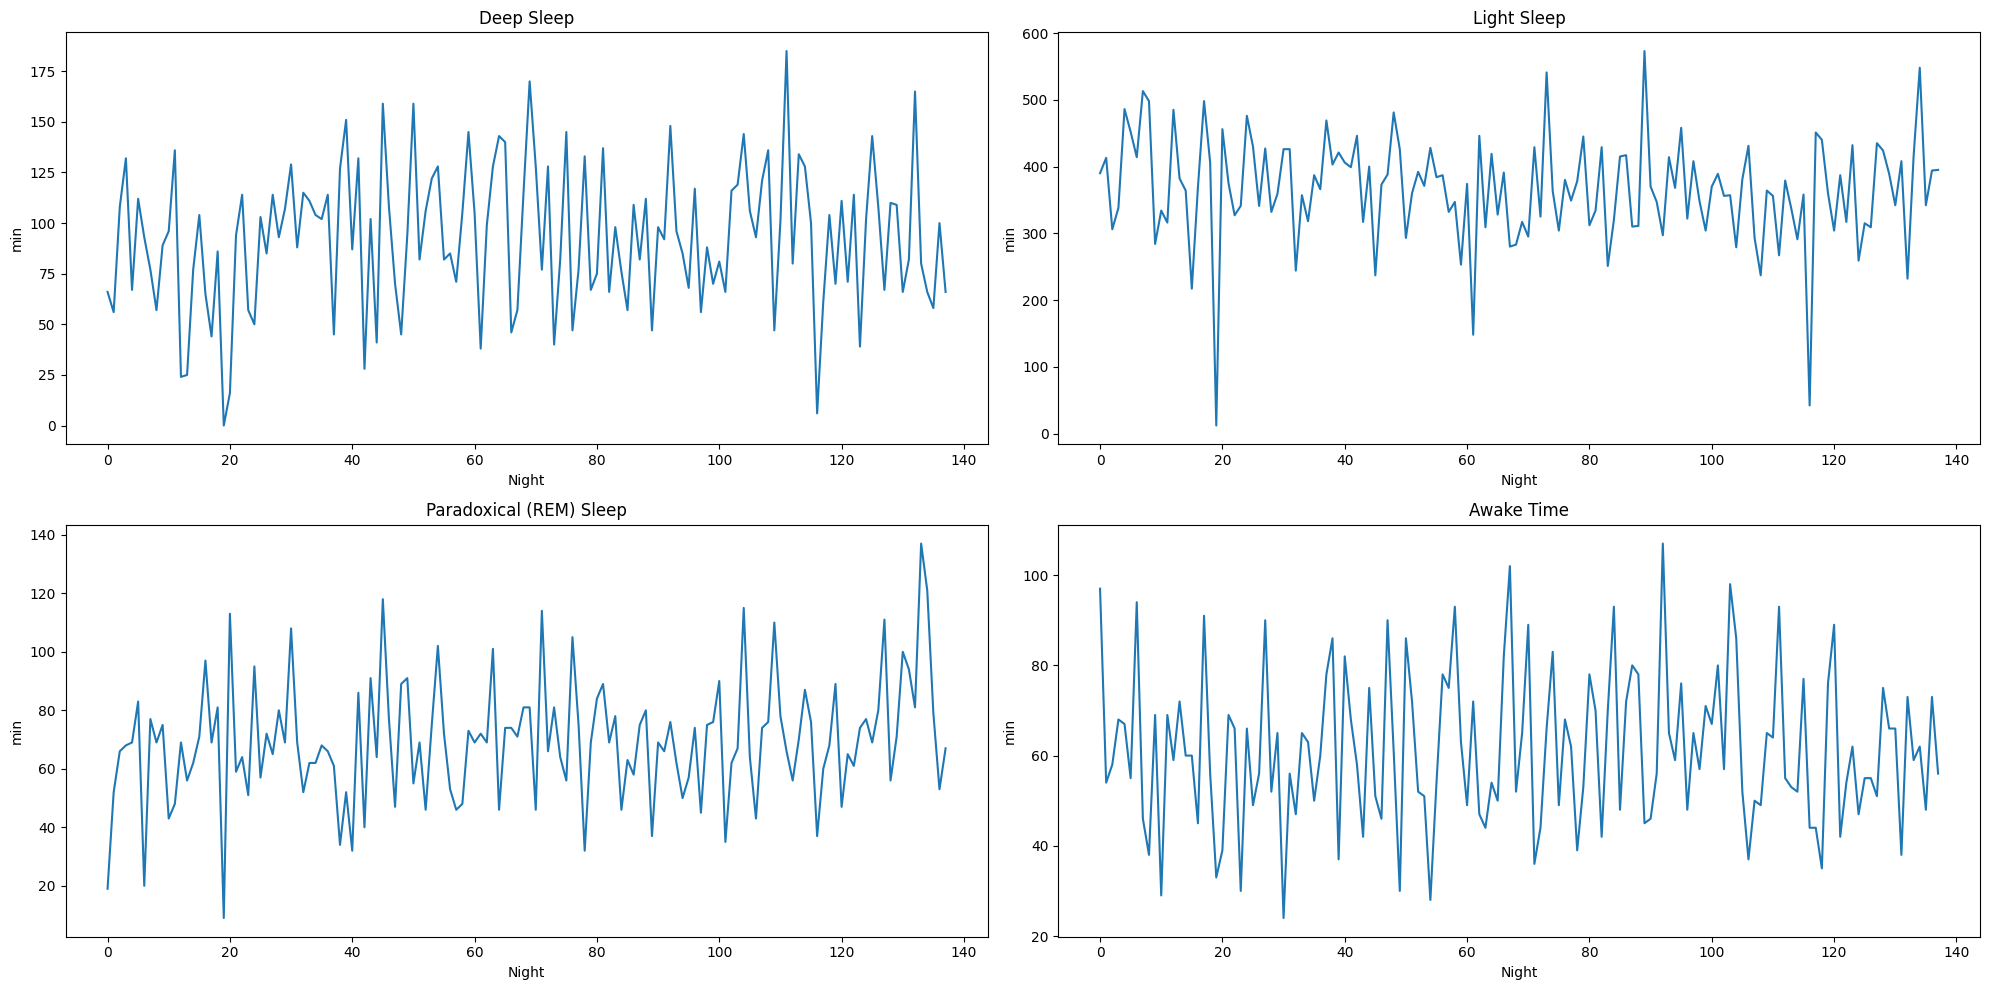

In [15]:
# Set up a figure with 4 subplots arranged in 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Plot Deep Sleep
axs[0, 0].plot(range(len(sleeping_stats_df)), sleeping_stats_df['Deep Sleep'])
axs[0, 0].set_title('Deep Sleep')
axs[0, 0].set_xlabel('Night')
axs[0, 0].set_ylabel('min')

axs[0, 1].plot(range(len(sleeping_stats_df)), sleeping_stats_df['Light Sleep'])
axs[0, 1].set_title('Light Sleep')
axs[0, 1].set_xlabel('Night')
axs[0, 1].set_ylabel('min')

# Plot Paradoxical (REM) Sleep
axs[1, 0].plot(range(len(sleeping_stats_df)), sleeping_stats_df['Paradoxical (REM) Sleep'])
axs[1, 0].set_title('Paradoxical (REM) Sleep')
axs[1, 0].set_xlabel('Night')
axs[1, 0].set_ylabel('min')

# Plot Awake Time
axs[1, 1].plot(range(len(sleeping_stats_df)), sleeping_stats_df['Awake time'])
axs[1, 1].set_title('Awake Time')
axs[1, 1].set_xlabel('Night')
axs[1, 1].set_ylabel('min')

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
medians = sleeping_stats_df.median()
print(medians)

Deep Sleep                  94.0
Light Sleep                369.5
Paradoxical (REM) Sleep     69.0
Awake time                  59.5
dtype: float64


# 5. Outlier Detection

In [17]:
distances = Mahanalobis_dist(sleeping_stats_df)

most_unusual_index = np.argmax(distances)
most_unusual_night = sleeping_stats_df.iloc[most_unusual_index]

print(f"Most unusual night details: (Night n°: {most_unusual_index})")
print(most_unusual_night)

Most unusual night details: (Night n°: 19)
Deep Sleep                  0
Light Sleep                12
Paradoxical (REM) Sleep     9
Awake time                 33
Name: 19, dtype: int64


/var/folders/lf/1l5wp0x94z148sykwdpk3wcw0000gn/T/ipykernel_9707/1144538904.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(most_unusual_index,most_unusual_night[0]+most_unusual_night[1]+most_unusual_night[2],'or')


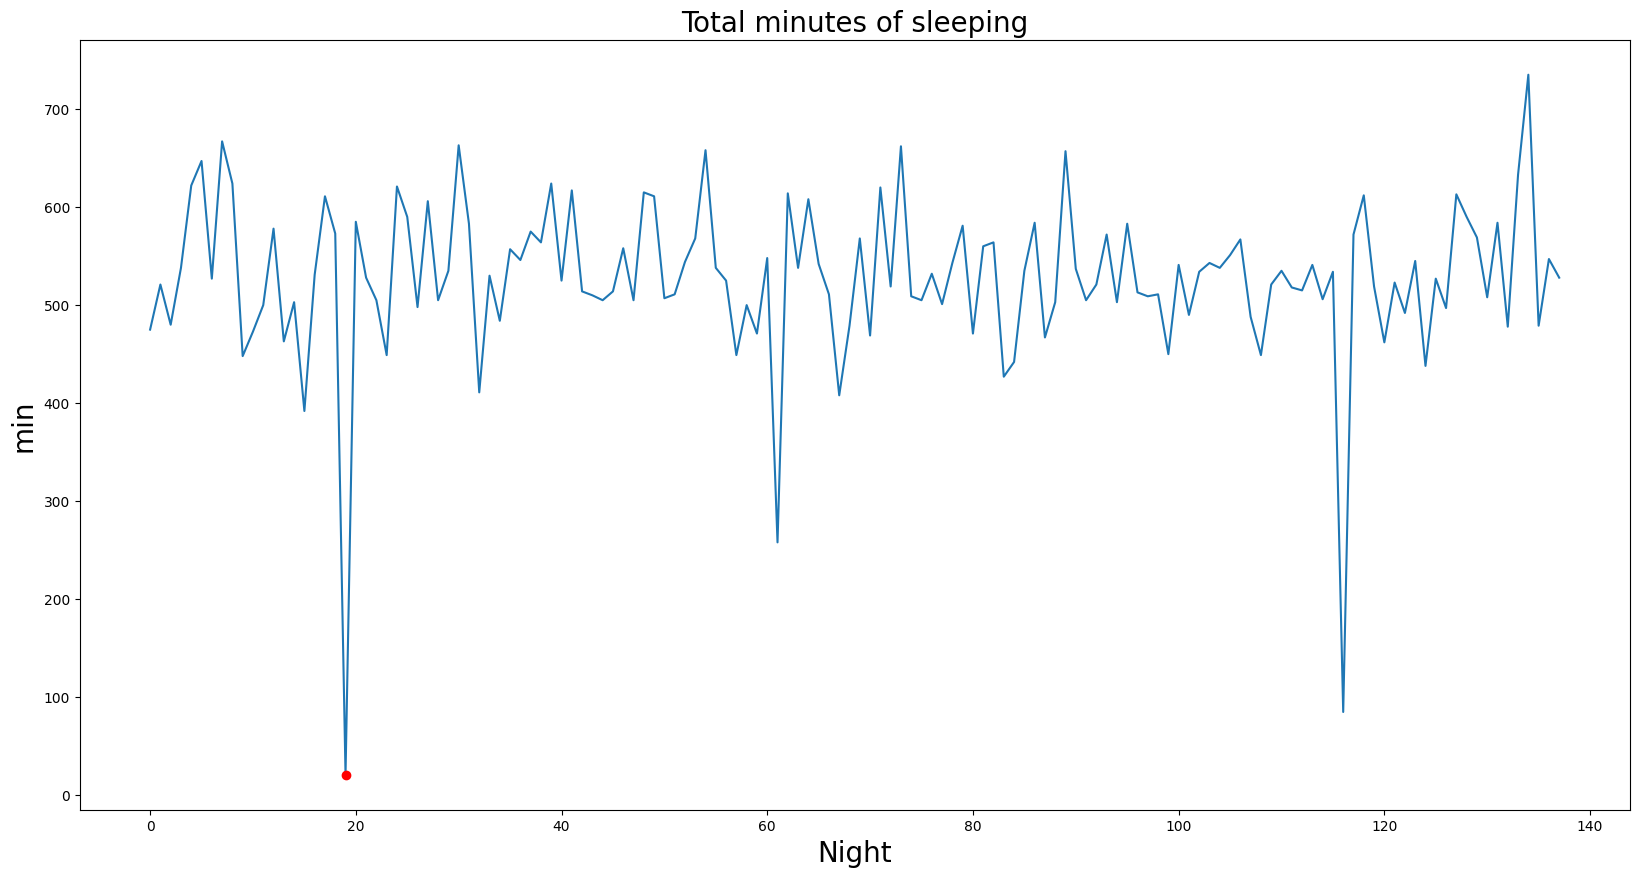

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(range(len(sleeping_stats_df)), sleeping_stats_df['Deep Sleep']+sleeping_stats_df['Light Sleep']+sleeping_stats_df['Paradoxical (REM) Sleep'])
plt.plot(most_unusual_index,most_unusual_night[0]+most_unusual_night[1]+most_unusual_night[2],'or')
plt.xlabel("Night", fontsize=20)
plt.ylabel("min", fontsize=20)
plt.title("Total minutes of sleeping", fontsize=20)
plt.show()

# 6. Comparison with Ideal Sleep Patterns.

#### Table with 1 Euclidean distance (abs version)

In [19]:
total_sleep = sleeping_stats_df.sum(axis=1)
tot = 450
ideal_pattern = pd.array([0.2*tot, 0.6*tot, 0.2*tot, tot])

nights_stats_abs = pd.DataFrame()

nights_stats_abs['Deep Sleep min'] = sleeping_stats_df['Deep Sleep']
nights_stats_abs['Light Sleep min'] = sleeping_stats_df['Light Sleep']
nights_stats_abs['Paradoxical Sleep min'] = sleeping_stats_df['Paradoxical (REM) Sleep']
nights_stats_abs['Total Sleep min'] = sleeping_stats_df['Deep Sleep']+sleeping_stats_df['Light Sleep']+sleeping_stats_df['Paradoxical (REM) Sleep']

nights_stats_abs

,Deep Sleep min,Light Sleep min,Paradoxical Sleep min,Total Sleep min
0,66,390,19,475
1,56,413,52,521
2,108,306,66,480
3,132,338,68,538
4,67,486,69,622
...,...,...,...,...
133,80,416,137,633
134,66,548,121,735
135,58,342,79,479
136,100,394,53,547


In [20]:
NS = nights_stats_abs.copy()

for i in range(len(NS)):
    NS.at[i,'Euclidean distance'] = Euclidean_dist(np.array([nights_stats_abs.iloc[i,0],nights_stats_abs.iloc[i,1],nights_stats_abs.iloc[i,2],nights_stats_abs.iloc[i,3]]), ideal_pattern)
NS

,Deep Sleep min,Light Sleep min,Paradoxical Sleep min,Total Sleep min,Euclidean distance
0,66,390,19,475,143.673240
1,56,413,52,521,167.600716
2,108,306,66,480,55.641711
3,132,338,68,538,120.896650
4,67,486,69,622,277.866875
...,...,...,...,...,...
133,80,416,137,633,238.985355
134,66,548,121,735,400.057496
135,58,342,79,479,84.675853
136,100,394,53,547,162.030861


#### Table with 1 Euclidean distance (% version)

In [21]:
total_sleep = sleeping_stats_df.sum(axis=1)
ideal_pattern = pd.array([20, 60, 20, 450])

nights_stats = pd.DataFrame()

nights_stats['Deep Sleep %'] = (sleeping_stats_df['Deep Sleep'] / total_sleep) * 100
nights_stats['Light Sleep %'] = (sleeping_stats_df['Light Sleep'] / total_sleep) * 100
nights_stats['Paradoxical Sleep %'] = (sleeping_stats_df['Paradoxical (REM) Sleep'] / total_sleep) * 100
nights_stats['Total Sleep'] = sleeping_stats_df['Deep Sleep']+sleeping_stats_df['Light Sleep']+sleeping_stats_df['Paradoxical (REM) Sleep']

nights_stats

,Deep Sleep %,Light Sleep %,Paradoxical Sleep %,Total Sleep
0,11.538462,68.181818,3.321678,475
1,9.739130,71.826087,9.043478,521
2,20.074349,56.877323,12.267658,480
3,21.782178,55.775578,11.221122,538
4,9.724238,70.537010,10.014514,622
...,...,...,...,...
133,11.560694,60.115607,19.797688,633
134,8.281054,68.757842,15.181932,735
135,11.005693,64.895636,14.990512,479
136,16.129032,63.548387,8.548387,547


In [22]:
NS = nights_stats.copy()

for i in range(len(NS)):
    NS.at[i,'Euclidean distance'] = Euclidean_dist(np.array([nights_stats.iloc[i,0],nights_stats.iloc[i,1],nights_stats.iloc[i,2],nights_stats.iloc[i,3]]), ideal_pattern)
NS

,Deep Sleep %,Light Sleep %,Paradoxical Sleep %,Total Sleep,Euclidean distance
0,11.538462,68.181818,3.321678,475,32.275474
1,9.739130,71.826087,9.043478,521,73.526778
2,20.074349,56.877323,12.267658,480,31.137530
3,21.782178,55.775578,11.221122,538,88.555579
4,9.724238,70.537010,10.014514,622,172.917118
...,...,...,...,...,...
133,11.560694,60.115607,19.797688,633,183.194640
134,8.281054,68.757842,15.181932,735,285.415920
135,11.005693,64.895636,14.990512,479,31.160228
136,16.129032,63.548387,8.548387,547,97.814697


#### Table with 4 Euclidean distances

In [23]:
total_sleep = sleeping_stats_df.sum(axis=1)
ideal_pattern = pd.array([20, 60, 20, 450])

nights_stats = pd.DataFrame()

nights_stats['Deep Sleep %'] = (sleeping_stats_df['Deep Sleep'] / total_sleep) * 100
nights_stats['Light Sleep %'] = (sleeping_stats_df['Light Sleep'] / total_sleep) * 100
nights_stats['Paradoxical Sleep %'] = (sleeping_stats_df['Paradoxical (REM) Sleep'] / total_sleep) * 100
nights_stats['Total Sleep'] = sleeping_stats_df['Deep Sleep']+sleeping_stats_df['Light Sleep']+sleeping_stats_df['Paradoxical (REM) Sleep']

nights_stats

,Deep Sleep %,Light Sleep %,Paradoxical Sleep %,Total Sleep
0,11.538462,68.181818,3.321678,475
1,9.739130,71.826087,9.043478,521
2,20.074349,56.877323,12.267658,480
3,21.782178,55.775578,11.221122,538
4,9.724238,70.537010,10.014514,622
...,...,...,...,...
133,11.560694,60.115607,19.797688,633
134,8.281054,68.757842,15.181932,735
135,11.005693,64.895636,14.990512,479
136,16.129032,63.548387,8.548387,547


In [24]:
Sleeping_Euc = [[0 for _ in range(4)] for _ in range(len(nights_stats))]

for i in range(4):
    for j in range(len(nights_stats)):
        Sleeping_Euc[j][i] = Euclidean_dist(np.array(nights_stats.iloc[j,i]), ideal_pattern[i])

Sleeping_Euc = pd.DataFrame(Sleeping_Euc, columns=['Deep Sleep', 'Light Sleep', 'Paradoxical (REM) Sleep', 'Total Sleep'])
Sleeping_Euc

,Deep Sleep,Light Sleep,Paradoxical (REM) Sleep,Total Sleep
0,8.461538,8.181818,16.678322,25.0
1,10.260870,11.826087,10.956522,71.0
2,0.074349,3.122677,7.732342,30.0
3,1.782178,4.224422,8.778878,88.0
4,10.275762,10.537010,9.985486,172.0
...,...,...,...,...
133,8.439306,0.115607,0.202312,183.0
134,11.718946,8.757842,4.818068,285.0
135,8.994307,4.895636,5.009488,29.0
136,3.870968,3.548387,11.451613,97.0


In [25]:
min_night = Sleeping_Euc['Paradoxical (REM) Sleep'].min()
min_night_idx = Sleeping_Euc['Paradoxical (REM) Sleep'].idxmin()
print('Night with min. REM: ',min_night_idx, 'with the min. distance of: ',min_night)

Night with min. REM:  133 with the min. distance of:  0.202312138728324


# 7. Sleep Recovery Score Calculation.

In [26]:
standard_deviations = np.std(nights_stats,axis=0)
SED = Sleeping_Euc/standard_deviations.values
SED

,Deep Sleep,Light Sleep,Paradoxical (REM) Sleep,Total Sleep
0,1.400511,0.951824,4.562047,0.293034
1,1.698327,1.375776,2.996955,0.832216
2,0.012306,0.363274,2.115040,0.351641
3,0.294977,0.491444,2.401300,1.031479
4,1.700792,1.225813,2.731346,2.016072
...,...,...,...,...
133,1.396831,0.013449,0.055339,2.145007
134,1.939661,1.018835,1.317894,3.340585
135,1.488692,0.569529,1.370253,0.339919
136,0.640703,0.412798,3.132378,1.136971


In [27]:
Unnormalized_Score = []
for index, row  in SED.iterrows():
    Unnormalized_Score.append(row.mean())

In [28]:
Score = 100*(1-(np.exp(Unnormalized_Score)/(1+np.exp(Unnormalized_Score))))
SED['Score'] = Score
SED

,Deep Sleep,Light Sleep,Paradoxical (REM) Sleep,Total Sleep,Score
0,1.400511,0.951824,4.562047,0.293034,14.162553
1,1.698327,1.375776,2.996955,0.832216,15.112323
2,0.012306,0.363274,2.115040,0.351641,32.947403
3,0.294977,0.491444,2.401300,1.031479,25.830442
4,1.700792,1.225813,2.731346,2.016072,12.802829
...,...,...,...,...,...
133,1.396831,0.013449,0.055339,2.145007,28.850489
134,1.939661,1.018835,1.317894,3.340585,12.962895
135,1.488692,0.569529,1.370253,0.339919,28.047668
136,0.640703,0.412798,3.132378,1.136971,20.904155


In [29]:
Best_night_index = SED['Score'].idxmax()
Best_night = SED.iloc[Best_night_index,:]
print('The best night is: ', Best_night_index,'\n', Best_night)

The best night is:  124 
 Deep Sleep                  0.170634
Light Sleep                 0.767565
Paradoxical (REM) Sleep     1.127965
Total Sleep                 0.140656
Score                      36.546892
Name: 124, dtype: float64


In [30]:
Worst_night_index = SED['Score'].idxmin()
Worst_night = SED.iloc[Worst_night_index,:]
print('The worst night is: ', Worst_night_index,'\n', Worst_night)

The worst night is:  19 
 Deep Sleep                 3.310299
Light Sleep                4.394841
Paradoxical (REM) Sleep    0.911772
Total Sleep                5.028459
Score                      3.194285
Name: 19, dtype: float64


# 8. Hierarchical Clustering Approach.

From this momement on, we use Kmeans frome the library

In [31]:
columns_to_adjust = nights_stats_abs.columns
DATA_8  = nights_stats_abs.copy()
DATA_8_Ward = nights_stats_abs.copy()
DATA_8_Kmeans = nights_stats_abs.copy()

#### Ward linkage

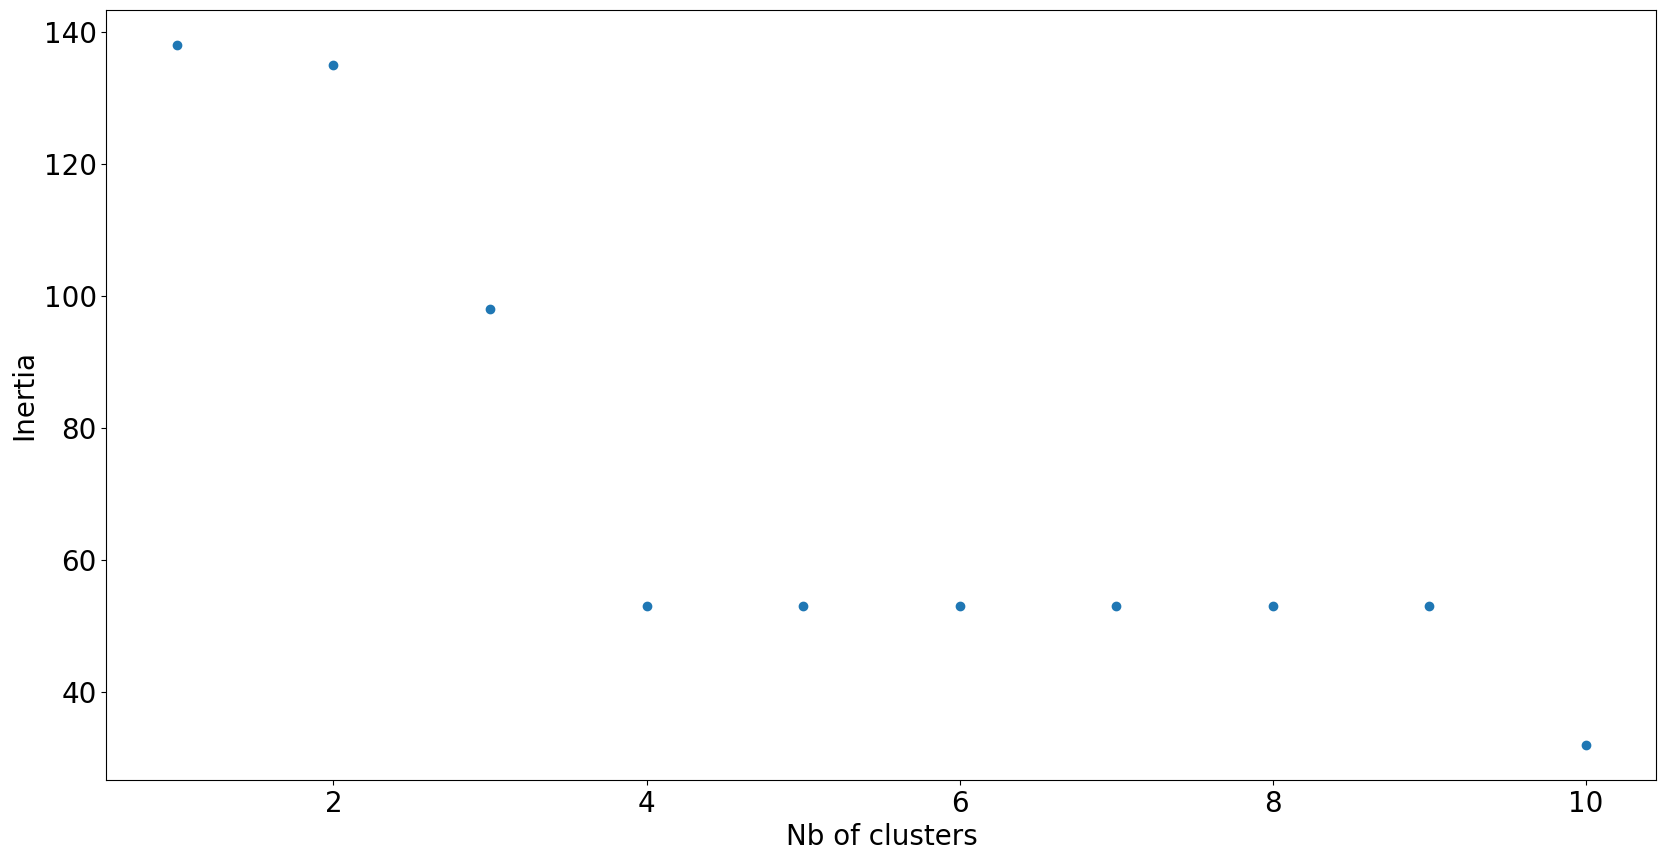

In [32]:
Prox_mat_py = distance_matrix(DATA_8_Ward, DATA_8_Ward)
max_K = 10
inertia = compute_inertia(Prox_mat_py, method_name='ward',nb_cluster_max=max_K)


plt.figure(figsize=(20, 10))  
plt.scatter(np.arange(1,max_K+1),inertia)  
plt.xlabel("Nb of clusters",fontsize=20)
plt.ylabel("Inertia",fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.show()

In [33]:
n_clusters = 4
output_pdist = sc_dist.squareform(Prox_mat_py)
output_linkage = sc.linkage(output_pdist, method='ward')
idx_best_cluster = sc.cut_tree(output_linkage,n_clusters)

In [34]:
DATA_8_Ward['Ward Linkage'] = idx_best_cluster
cluster_centroids = DATA_8_Ward.groupby('Ward Linkage').mean()
cluster_centroids.reset_index(inplace=True)
cluster_centroids

,Ward Linkage,Deep Sleep min,Light Sleep min,Paradoxical Sleep min,Total Sleep min
0,0,82.773585,377.377358,64.415094,524.566038
1,1,118.066667,298.800000,70.844444,487.711111
2,2,82.081081,452.081081,77.216216,611.378378
3,3,14.666667,67.333333,39.333333,121.333333


In [36]:
Sleeping_Ward = DATA_8_Ward.copy()

ordering_states = np.argsort(cluster_centroids['Ward Linkage'])

for linkage in cluster_centroids['Ward Linkage'].unique():
    centroid_values = cluster_centroids.loc[cluster_centroids['Ward Linkage'] == ordering_states[linkage], columns_to_adjust].values
    Sleeping_Ward.loc[Sleeping_Ward['Ward Linkage'] == linkage, columns_to_adjust] -= centroid_values

/var/folders/lf/1l5wp0x94z148sykwdpk3wcw0000gn/T/ipykernel_9707/1441758936.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-16.77358491 -26.77358491  10.22641509 -57.77358491  -5.77358491
 -17.77358491  11.22641509   2.22641509  10.22641509  24.22641509
  28.22641509  19.22641509  31.22641509  44.22641509   4.22641509
 -54.77358491 -41.77358491  25.22641509 -12.77358491  -0.77358491
  23.22641509  39.22641509  -0.77358491   2.22641509  22.22641509
 -36.77358491  -0.77358491 -35.77358491  -5.77358491  50.22641509
 -25.77358491  15.22641509   9.22641509   2.22641509 -26.77358491
   5.22641509  -1.77358491 -16.77358491  33.22641509  36.22641509
  23.22641509 -35.77358491  18.22641509  -2.77358491  17.22641509
 -12.77358491 -11.77358491 -43.77358491  26.22641509 -16.77358491
 -24.77358491  17.22641509 -16.77358491]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
 

In [38]:
Sleeping_Ward = Sleeping_Ward[columns_to_adjust]
Unnormalized_Score_ward = []
for index, row  in Sleeping_Ward.iterrows():
    Unnormalized_Score_ward.append(row.mean())

In [39]:
Score_ward = 100*(1-(np.exp(Unnormalized_Score_ward)/(1+np.exp(Unnormalized_Score_ward))))
Score_ward = np.array(Score_ward)

#### K-means

In [40]:
y = sleeping_stats_df.to_numpy()
dist_all=dist_per_cluster(y,max_k=max_K,replic=25)
kl = kneed.KneeLocator(np.arange(1, np.size(dist_all)+1), dist_all, curve="convex", direction="decreasing")
print("Optimal number of clusters with Squared distance: " + str(kl.elbow))

Optimal number of clusters with Squared distance: 4


In [41]:
output_Kmean = Kmeans_algo(nights_stats,nb_K=4,replic=5)
idx_best_Kmeans,idx_all,sq_dist_best = output_Kmean
DATA_8_Kmeans['Kmeans'] = idx_best_Kmeans
Kmeans_centroids = DATA_8_Kmeans.groupby('Kmeans').mean()
Kmeans_centroids.reset_index(inplace=True)

ordering_states = np.argsort(Kmeans_centroids['Kmeans'])

In [42]:
Sleeping_Kmeans = DATA_8_Kmeans.copy()
Sleeping_Kmeans

,Deep Sleep min,Light Sleep min,Paradoxical Sleep min,Total Sleep min,Kmeans
0,66,390,19,475,2
1,56,413,52,521,3
2,108,306,66,480,2
3,132,338,68,538,3
4,67,486,69,622,1
...,...,...,...,...,...
133,80,416,137,633,1
134,66,548,121,735,1
135,58,342,79,479,2
136,100,394,53,547,3


In [43]:
Kmeans_centroids[columns_to_adjust] = Kmeans_centroids[columns_to_adjust].astype(float)


for linkage in Kmeans_centroids['Kmeans'].unique():
    Kmeans_centroid_values = Kmeans_centroids.loc[Kmeans_centroids['Kmeans'] == ordering_states[linkage], columns_to_adjust].values[0]
    Sleeping_Kmeans.loc[Sleeping_Kmeans['Kmeans'] == linkage, columns_to_adjust] -= Kmeans_centroid_values

Sleeping_Kmeans

/var/folders/lf/1l5wp0x94z148sykwdpk3wcw0000gn/T/ipykernel_9707/1868357513.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-14.66666667  23.33333333  -8.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Sleeping_Kmeans.loc[Sleeping_Kmeans['Kmeans'] == linkage, columns_to_adjust] -= Kmeans_centroid_values
/var/folders/lf/1l5wp0x94z148sykwdpk3wcw0000gn/T/ipykernel_9707/1868357513.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-55.33333333  80.66666667 -25.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Sleeping_Kmeans.loc[Sleeping_Kmeans['Kmeans'] == linkage, columns_to_adjust] -= Kmeans_centroid_values
/var/folders/lf/1l5wp0x94z148sykwdpk3wcw0000gn/T/ipykernel_9707/1868357513.py:6: FutureWarning: Setting an item 

,Deep Sleep min,Light Sleep min,Paradoxical Sleep min,Total Sleep min,Kmeans
0,-28.592593,88.925926,-44.000000,16.333333,2
1,-44.068493,54.397260,-16.671233,-6.342466,3
2,13.407407,4.925926,3.000000,21.333333,2
3,31.931507,-20.602740,-0.671233,10.657534,3
4,-15.228571,32.657143,-9.428571,8.000000,1
...,...,...,...,...,...
133,-2.228571,-37.342857,58.571429,19.000000,1
134,-16.228571,94.657143,42.571429,121.000000,1
135,-36.592593,40.925926,16.000000,20.333333,2
136,-0.068493,35.397260,-15.671233,19.657534,3


In [44]:
Sleeping_Kmeans = Sleeping_Kmeans[columns_to_adjust]
Unnormalized_Score_Kmeans = []
for index, row  in Sleeping_Kmeans.iterrows():
    Unnormalized_Score_Kmeans.append(row.mean())

In [45]:
Score_Kmeans = 100*(1-(np.exp(Unnormalized_Score_Kmeans)/(1+np.exp(Unnormalized_Score_Kmeans))))
Score_Kmeans = np.array(Score_Kmeans)

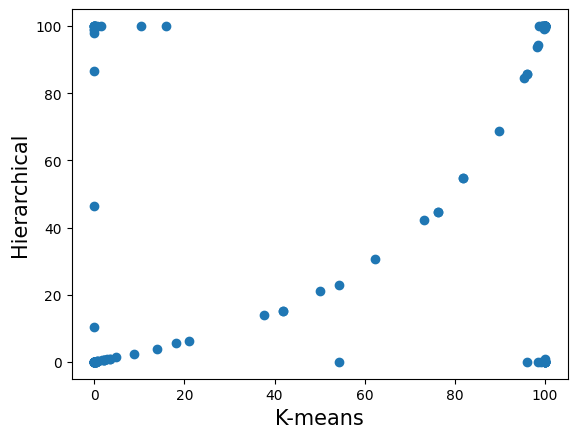

In [46]:
plt.scatter(Score_Kmeans,Score_ward)
plt.xlabel("K-means",fontsize=15)
plt.ylabel("Hierarchical",fontsize=15)
plt.show()

In [51]:
CORR = np.corrcoef(Score_Kmeans,Score_ward)
CORR[0,1]

0.5032497658173526

In [ ]:
correlation = np.corrcoef(Score_Kmeans, Score_ward)[0, 1]
print("Correlation:", correlation)

Correlation: 0.5032497658173526


# 9. Final Sleep Recovery Score.

In [49]:
Final = []
for index, row in DATA_8.iterrows():
    Final.append(np.mean([Score_Kmeans[index],Score_ward[index]]))
Final = pd.DataFrame(Final, columns=['Final score'])
Final.describe()

,Final score
count,138.000000
mean,49.810927
std,41.030891
min,0.000000
25%,1.192100
50%,50.001624
75%,99.886910
max,100.000000


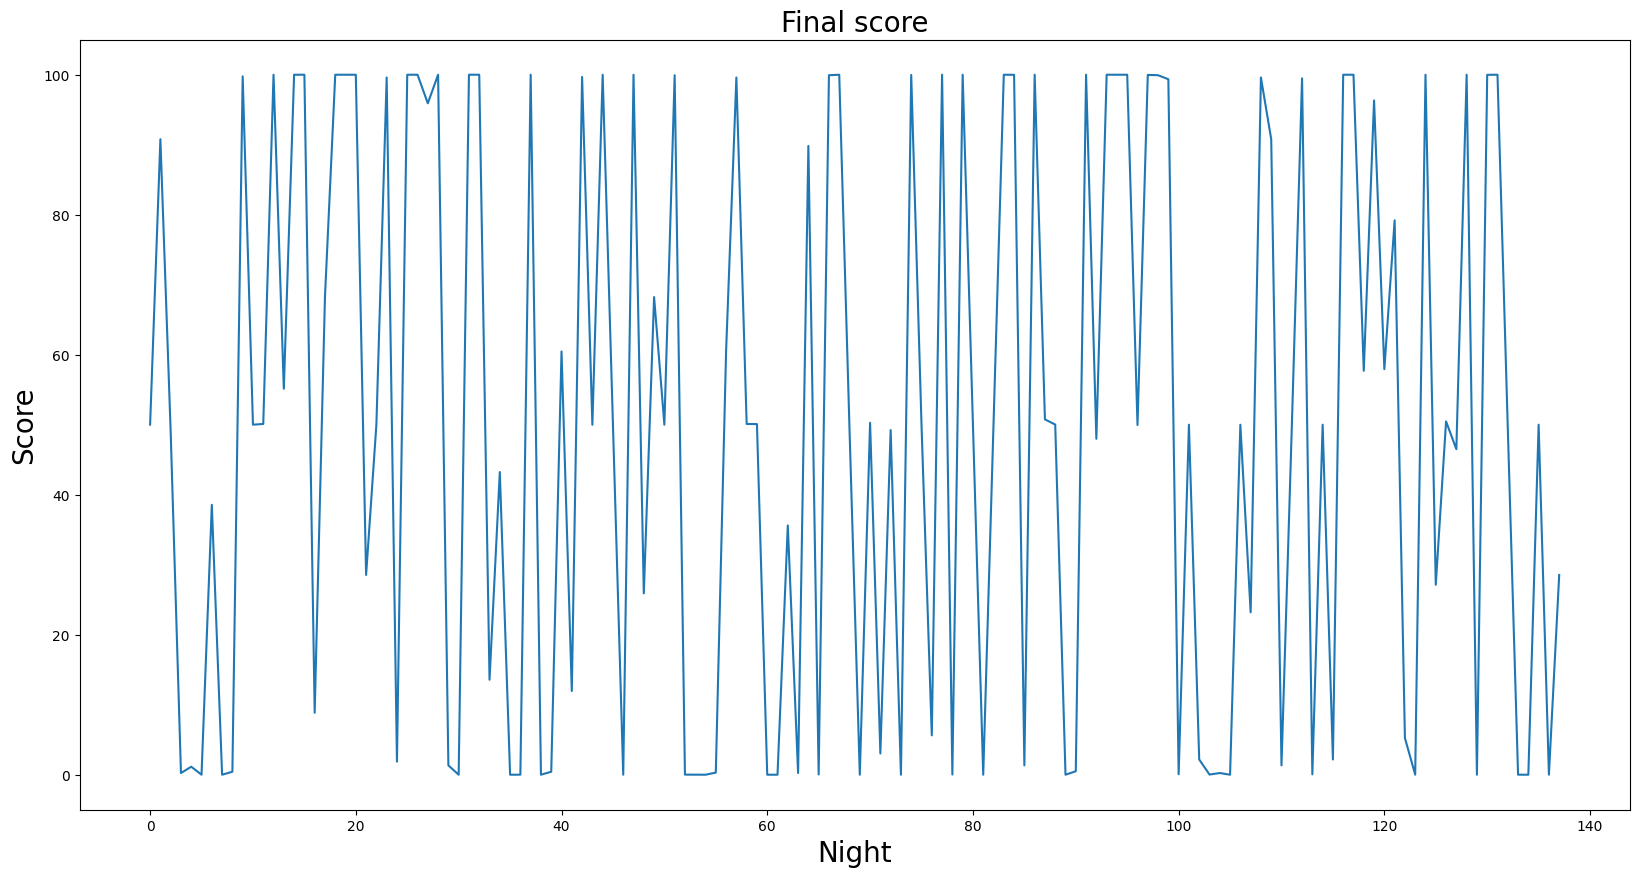

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(range(len(Final)),Final['Final score'])
plt.xlabel("Night", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.title("Final score", fontsize=20)
plt.show()